In [25]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import urllib.request
import datetime
import json
import glob
import sys
import os

import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.grid'] = False

pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)
pd.set_option('display.width', 100)

pd.options.display.float_format = '{:.2f}'.format

In [8]:
class NaverDataLabOpenAPI():
    """
    네이버 데이터랩 오픈 API 컨트롤러 클래스
    """

    def __init__(self, client_id, client_secret):
        """
        인증키 설정 및 검색어 그룹 초기화
        """
        self.client_id = client_id
        self.client_secret = client_secret
        self.keywordGroups = []
        self.url = "https://openapi.naver.com/v1/datalab/search"
        
    def add_keyword_groups(self, group_dict):
        """
        검색어 그룹 추가
        """

        keyword_gorup = {
            'groupName': group_dict['groupName'],
            'keywords': group_dict['keywords']
        }
        
        self.keywordGroups.append(keyword_gorup)
        print(f">>> Num of keywordGroups: {len(self.keywordGroups)}")
        
        
    def get_data(self, startDate, endDate, timeUnit, device, ages, gender):
        """
        요청 결과 반환
        """

        # Request body
        body = json.dumps({
            "startDate": startDate,
            "endDate": endDate,
            "timeUnit": timeUnit,
            "keywordGroups": self.keywordGroups,
            "device": device,
            "ages": ages,
            "gender": gender
        }, ensure_ascii=False)
        
        # Results
        request = urllib.request.Request(self.url)
        request.add_header("X-Naver-Client-Id",self.client_id)
        request.add_header("X-Naver-Client-Secret",self.client_secret)
        request.add_header("Content-Type","application/json")
        response = urllib.request.urlopen(request, data=body.encode("utf-8"))
        rescode = response.getcode()
        if(rescode==200):
            # Json Result
            result = json.loads(response.read())
            
            df = pd.DataFrame(result['results'][0]['data'])[['period']]
            for i in range(len(self.keywordGroups)):
                tmp = pd.DataFrame(result['results'][i]['data'])
                tmp = tmp.rename(columns={'ratio': result['results'][i]['title']})
                df = pd.merge(df, tmp, how='left', on=['period'])
            self.df = df.rename(columns={'period': '날짜'})
            self.df['날짜'] = pd.to_datetime(self.df['날짜'])
            
        else:
            print("Error Code:" + rescode)
            
        return self.df
    
    def plot_daily_trend(self):
        """
        일 별 검색어 트렌드 그래프 출력
        """
        colList = self.df.columns[1:]
        n_col = len(colList)

        fig = plt.figure(figsize=(12,6))
        plt.title('일 별 검색어 트렌드', size=20, weight='bold')
        for i in range(n_col):
            sns.lineplot(x=self.df['날짜'], y=self.df[colList[i]], label=colList[i])
        plt.legend(loc='upper right')
        
        return fig

    
    def plot_monthly_trend(self):
        """
        월 별 검색어 트렌드 그래프 출력
        """
        df = self.df.copy()
        df_0 = df.groupby(by=[df['날짜'].dt.year, df['날짜'].dt.month]).mean().droplevel(0).reset_index().rename(columns={'날짜': '월'})
        df_1 = df.groupby(by=[df['날짜'].dt.year, df['날짜'].dt.month]).mean().droplevel(1).reset_index().rename(columns={'날짜': '년도'})

        df = pd.merge(df_1[['년도']], df_0, how='left', left_index=True, right_index=True)
        df['날짜'] = pd.to_datetime(df[['년도','월']].assign(일=1).rename(columns={"년도": "year", "월":'month','일':'day'}))
        
        colList = df.columns.drop(['날짜','년도','월'])
        n_col = len(colList)
                
        fig = plt.figure(figsize=(12,6))
        plt.title('월 별 검색어 트렌드', size=20, weight='bold')
        for i in range(n_col):
            sns.lineplot(x=df['날짜'], y=df[colList[i]], label=colList[i])
        plt.legend(loc='upper right')
        
        return fig

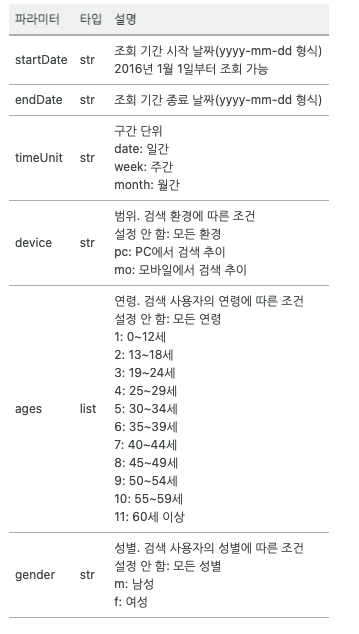

In [9]:
keyword_group_set = {
    'keyword_group_1': {'groupName': "애플", 'keywords': ["애플","Apple","AAPL"]},
    'keyword_group_2': {'groupName': "아마존", 'keywords': ["아마존","Amazon","AMZN"]},
    'keyword_group_3': {'groupName': "구글", 'keywords': ["구글","Google","GOOGL"]},
    'keyword_group_4': {'groupName': "테슬라", 'keywords': ["테슬라","Tesla","TSLA"]},
    'keyword_group_5': {'groupName': "페이스북ㅁ", 'keywords': ["페이스북","Facebook","FB"]}
}

In [22]:
# API 인증 정보 설정
client_id = "bfyYjqp9aeVgez9TWrQm"
client_secret = "pirblBFcyM"

# 요청 파라미터 설정
startDate = "2020-01-01"
endDate = "2022-07-01"
timeUnit = 'date'
device = ''
ages = []
gender = ''

# 데이터 프레임 정의
naver = NaverDataLabOpenAPI(client_id=client_id, client_secret=client_secret)

naver.add_keyword_groups(keyword_group_set['keyword_group_1'])
naver.add_keyword_groups(keyword_group_set['keyword_group_2'])
naver.add_keyword_groups(keyword_group_set['keyword_group_3'])
naver.add_keyword_groups(keyword_group_set['keyword_group_4'])
naver.add_keyword_groups(keyword_group_set['keyword_group_5'])

df = naver.get_data(startDate, endDate, timeUnit, device, ages, gender)

>>> Num of keywordGroups: 1
>>> Num of keywordGroups: 2
>>> Num of keywordGroups: 3
>>> Num of keywordGroups: 4
>>> Num of keywordGroups: 5


In [23]:
df

,날짜,애플,아마존,구글,테슬라,페이스북
0,2020-01-01,2.89,1.36,56.16,1.37,32.61
1,2020-01-02,3.28,1.67,62.64,1.43,30.05
2,2020-01-03,3.16,1.61,61.69,1.47,29.34
3,2020-01-04,2.99,1.40,59.07,1.47,28.64
4,2020-01-05,2.99,1.52,59.56,1.69,28.91
...,...,...,...,...,...,...
908,2022-06-27,3.30,1.08,55.01,3.38,10.90
909,2022-06-28,3.45,1.18,54.23,4.16,10.79
910,2022-06-29,3.56,1.14,54.78,4.58,10.75
911,2022-06-30,3.54,1.07,54.83,4.51,10.75


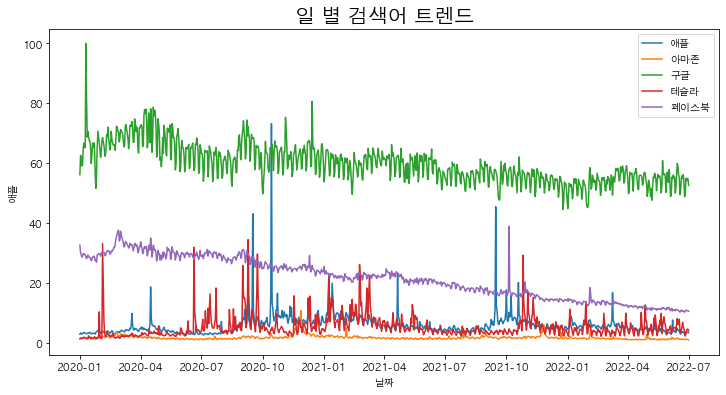

In [26]:
fig_1 = naver.plot_daily_trend()

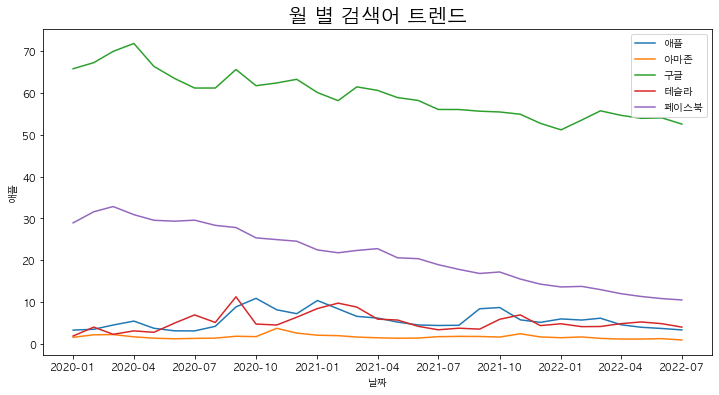

In [27]:
fig_2 = naver.plot_monthly_trend()